# Setup notebook

In [1]:
import sys
from collections import namedtuple

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import statsmodels.api as sm
import utide
from joblib import Parallel, delayed
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import STL, seasonal_decompose

sys.path.append("..")
from src import definitions as defs
from src import features, models

%load_ext autoreload
%autoreload 2
%matplotlib widget
%config Completer.use_jedi = False

plt.rcParams['figure.constrained_layout.use'] = True

In [2]:
wdir = defs.ROOT / "data"

In [3]:
data = pd.read_csv(wdir / "processed" / "sutarkhali_adjusted.csv", index_col="datetime", parse_dates=True, infer_datetime_format=True, squeeze=True)
data.index = pd.DatetimeIndex(data=data.index, freq="infer")

<AxesSubplot:xlabel='datetime'>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
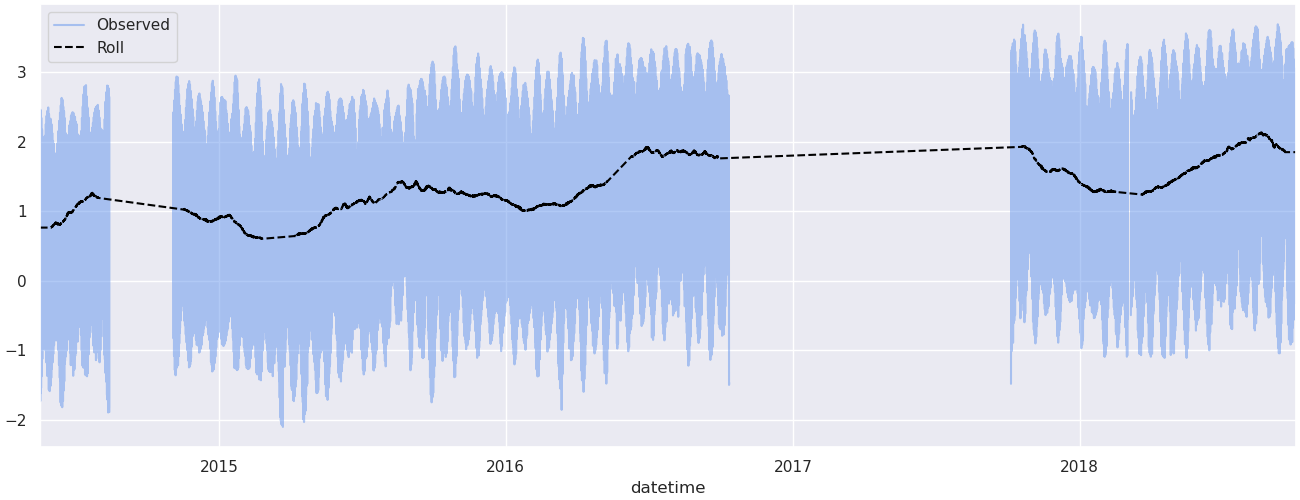

In [4]:
data = data.to_frame(name="obs")

window = pd.Timedelta("28D")
min_periods = window // data.index.freq

data["roll"] = data.obs.rolling(window=window, center=True, min_periods=min_periods).median().interpolate(method="time", limit_direction="both")

fig, ax = plt.subplots(figsize=(13, 5), constrained_layout=True)

step = 6

data.iloc[::step].obs.plot(kind="line", color="cornflowerblue", alpha=0.5, ax=ax, label="Observed", legend=True)
data.iloc[::step].roll.plot(kind="line", ax=ax, color="black", label="Roll", ls="--", legend=True)

<AxesSubplot:xlabel='datetime'>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
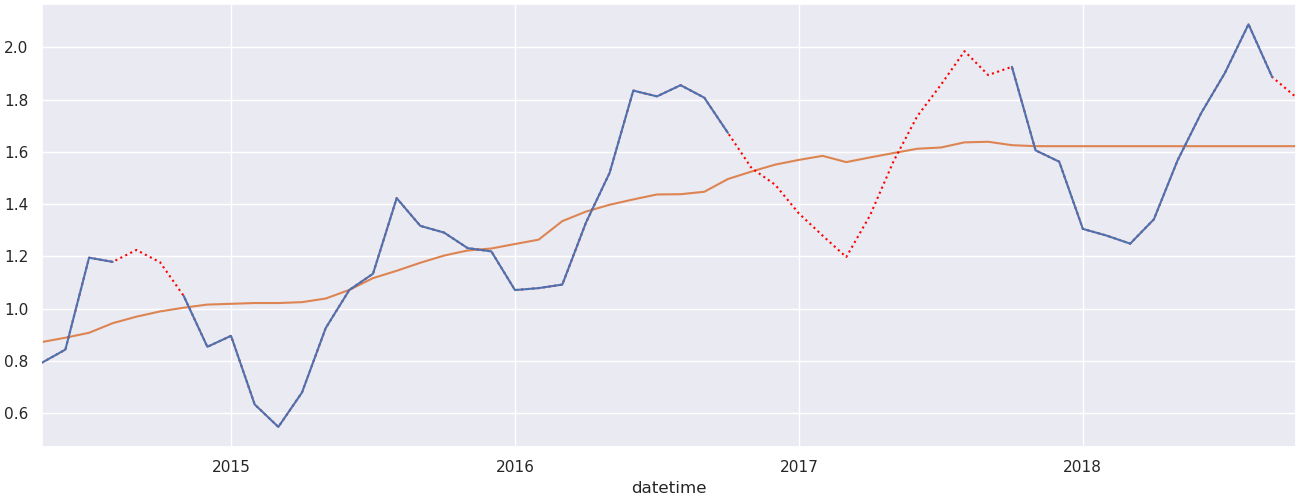

In [5]:
fig, ax = plt.subplots(figsize=(13, 5), constrained_layout=True)

yearly = data.obs.groupby(by=data.index.year).agg("median")
monthly = data.obs.groupby(by=pd.Grouper(freq="MS")).agg(vals="median", nulls=lambda x: 1 - x.count() / (7*24*60/10))
monthly.loc[monthly.nulls > 0.3, "vals"] = np.nan
monthly.vals.plot(ax=ax, zorder=10)
trend = monthly.vals.rolling(window=pd.Timedelta("365.25D") * 2, center=True).mean()
trend.plot(ax=ax)
monthly.vals = monthly.vals - trend
mean_monthly = monthly.vals.groupby(monthly.index.month).mean()
monthly.loc[monthly.nulls > 0.3, "vals"] = mean_monthly.loc[monthly.loc[monthly.nulls > 0.3].index.month].values
monthly = monthly.vals + trend

monthly.plot(ax=ax, color="red", ls=":")


/opt/conda/envs/python/lib/python3.9/site-packages/statsmodels/tsa/seasonal.py:338: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
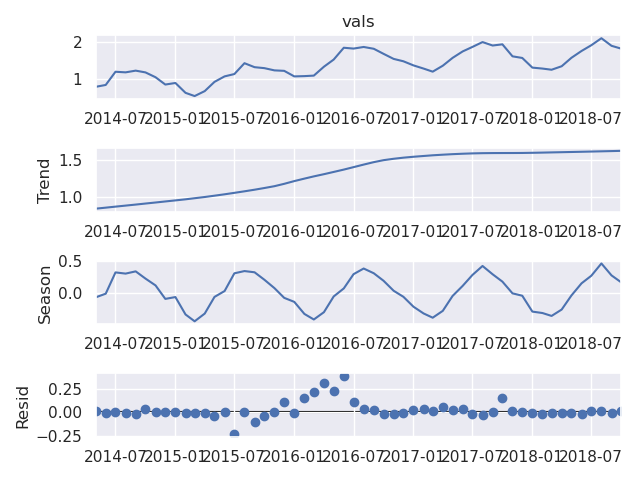

In [6]:
stl = STL(endog=monthly, seasonal=13, robust=True)
res = stl.fit()

data["seasonal"] = res.seasonal.reindex(index=data.index).interpolate(method="time", limit_direction="both")
data["trend"] = res.trend.reindex(index=data.index).interpolate(method="time", limit_direction="both")
mean_seasonal = data.seasonal.groupby(data.index.month).mean()

res.plot();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
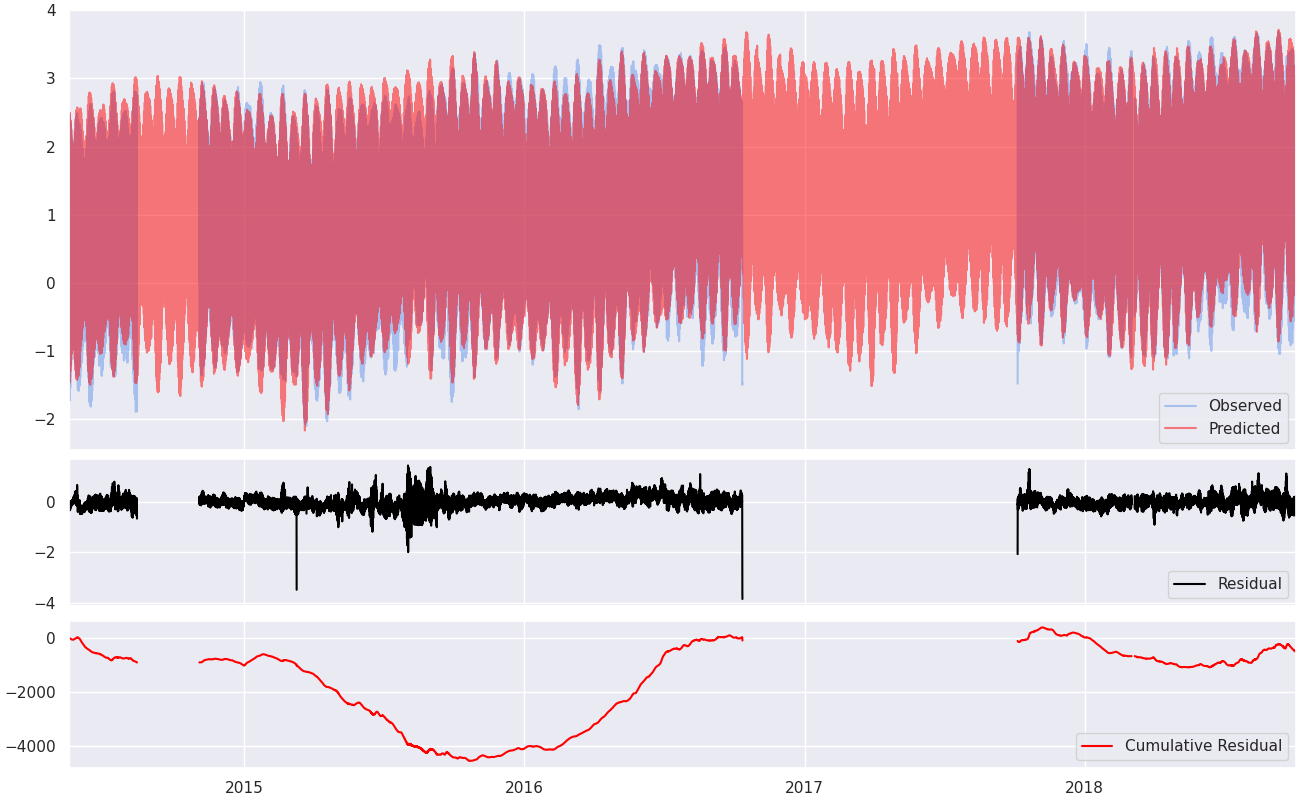

In [7]:
lat = 22.49984514299519
elev = (data.obs - data.trend - data.seasonal).values
time = mdates.date2num((data.index - pd.Timedelta("6 hours")).to_pydatetime())

coef = utide.solve(t=time, u=elev, lat=lat, conf_int="MC", method="ols", trend=False, nodal=True, constit="auto", verbose=False)
data["pred"] = utide.reconstruct(t=mdates.date2num((data.index - pd.Timedelta("6 hours")).to_pydatetime()), coef=coef, verbose=False).h + data.trend + mean_seasonal.loc[data.index.month].values
data["res"] = data.obs - data.pred

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 8), nrows=3, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]}, constrained_layout=True)

step = 6

data.iloc[::step].obs.plot(kind="line", color="cornflowerblue", alpha=0.5, ax=ax1, label="Observed", legend=True)
data.iloc[::step].pred.plot(kind="line", color="red", alpha=0.5, ax=ax1, label="Predicted", legend=True)
data.iloc[::step].res.plot(kind="line", ax=ax2, color="black", label="Residual", legend=True)
data.res.cumsum().iloc[::step].plot(kind="line", ax=ax3, color="red", label="Cumulative Residual", legend=True)

ax3.set_xlim(data.index[0], data.index[-1]);
ax3.set_xlabel("");

ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
ax3.legend(loc='lower right')

In [8]:
tides = pd.DataFrame(index=pd.date_range(start="2020", end="2040", closed="left", freq="1H", name="datetime"))
new_time = mdates.date2num((tides.index - pd.Timedelta("6 hours")).to_pydatetime())
tides["elev"] = utide.reconstruct(t=new_time, coef=coef, verbose=False).h + mean_seasonal.loc[tides.index.month].values

<AxesSubplot:xlabel='datetime'>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
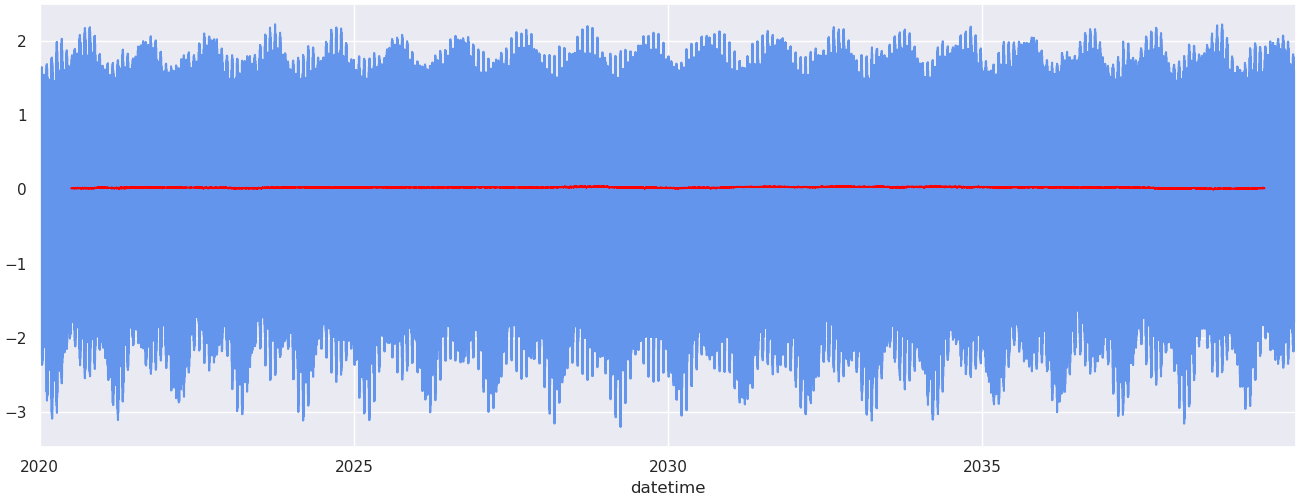

In [9]:
fig, ax = plt.subplots(figsize=(13, 5), constrained_layout=True)

tides.elev.plot(ax=ax, color="cornflowerblue")
tides.elev.rolling(window=pd.Timedelta("365.25D"), center=True, min_periods=pd.Timedelta("365.25D")//tides.index.freq).median().plot(ax=ax, color="red")

In [10]:
tides[["high", "low"]] = False
distance = pd.Timedelta("1H") / tides.index.freq * 8

hi = find_peaks(x=tides.elev.values, distance=distance)[0]
lo = find_peaks(x=tides.elev.values * -1, distance=distance)[0]

tides.loc[tides.iloc[hi].index, "high"] = True
tides.loc[tides.iloc[lo].index, "low"] = True

In [11]:
tides["high_roll"] = tides.loc[tides.high == True].elev.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=tides.index).interpolate(method="time", limit_direction="both")
tides["low_roll"] = tides.loc[tides.low == True].elev.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=tides.index).interpolate(method="time", limit_direction="both")
tides["amp_roll"] = tides.high_roll - tides.low_roll

In [12]:
window = pd.Timedelta("27 hour")
exog = (tides.index - tides.index[0]).total_seconds().astype(int).values
frac = window / pd.Timedelta(tides.index.freq) / len(tides)
# delta = window * 500 / pd.Timedelta(tides.index.freq)
endogs = (tides.high_roll.values, tides.low_roll.values)
high_smooth, low_smooth = Parallel(n_jobs=2, max_nbytes=None)(delayed(sm.nonparametric.lowess)(endog=endog, exog=exog, frac=frac, is_sorted=True) for endog in endogs)

In [13]:
tides.loc[pd.TimedeltaIndex(list(zip(*high_smooth))[0], unit="s") + tides.index[0], "high_smooth"] = list(zip(*high_smooth))[1]
tides.loc[pd.TimedeltaIndex(list(zip(*low_smooth))[0], unit="s") + tides.index[0], "low_smooth"] = list(zip(*low_smooth))[1]
tides["amp_smooth"] = tides.high_smooth - tides.low_smooth

In [14]:
tides[["spring", "neap"]] = False
distance = pd.Timedelta("1H") / tides.index.freq * 24 * 11 # search distance in hours
hi = find_peaks(x=tides.amp_smooth.values, distance=distance, height=3.0)[0]
lo = find_peaks(x=tides.amp_smooth.values * -1, distance=distance, height=-3.0)[0]
tides.loc[tides.iloc[hi].index, "spring"] = True
tides.loc[tides.iloc[lo].index, "neap"] = True

/tmp/ipykernel_186818/1812373367.py:36: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
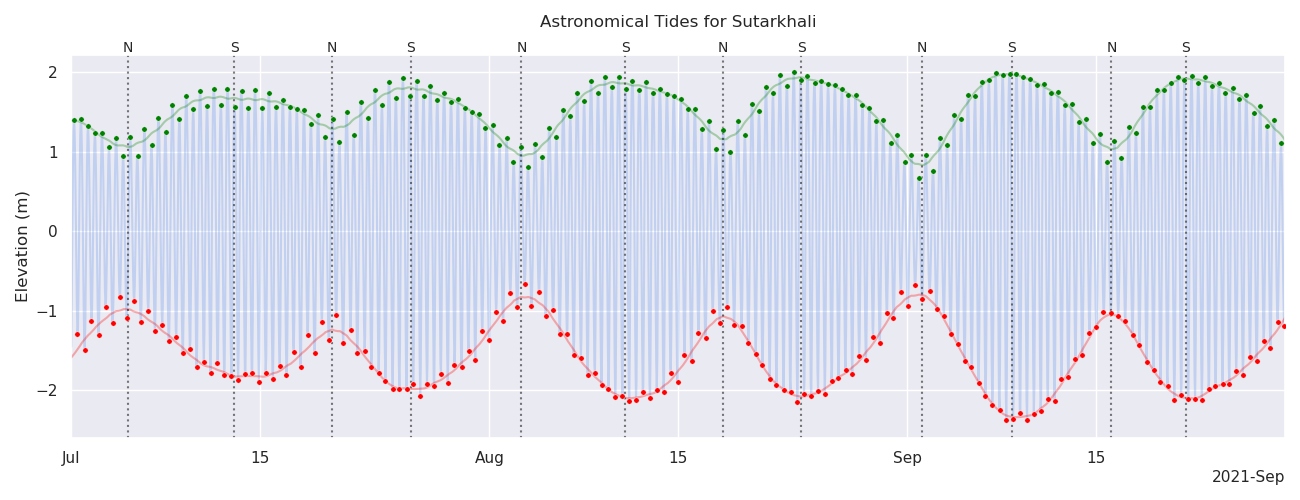

In [15]:
start = pd.to_datetime("2021-07-01")
end = start + pd.Timedelta("90D")

pdata = tides.loc[start:end].reset_index()

fig = plt.figure(figsize=(13, 5))
ax = fig.subplots()

sns.lineplot(data=pdata, x="datetime", y="elev", color="cornflowerblue", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="high_smooth", color="green", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="low_smooth", color="red", alpha=0.3, ax=ax)
# sns.lineplot(data=pdata, x="datetime", y="amp_smooth", color="black", alpha=0.3, ax=ax)

sns.scatterplot(data=pdata.loc[pdata.high == True], x="datetime", y="elev", color="green", s=15, ax=ax, zorder=15)
sns.scatterplot(data=pdata.loc[pdata.low == True], x="datetime", y="elev", color="red", s=15, ax=ax, zorder=15)

for loc in pdata.loc[pdata.spring == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="S", rotation=0, ha="center", va="bottom")

for loc in pdata.loc[pdata.neap == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="N", rotation=0, ha="center", va="bottom")

title = "Astronomical Tides for Sutarkhali"
xlabel = ""
ylabel = "Elevation (m)"

locator = locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

ax.xaxis.set(major_locator=locator, major_formatter=formatter)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.set_title(label=title, pad=20)
ax.set_xlim(start, end)
fig.tight_layout()

In [158]:
springs = tides.loc[tides.spring == True].apply(
    lambda x: pd.Series(data=(
        tides.loc[tides.high == True].elev.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean(),
        tides.loc[tides.low == True].elev.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean()),
        index=("high", "low")),
        axis=1)

neaps = tides.loc[tides.neap == True].apply(
    lambda x: pd.Series(data=(
        tides.loc[tides.high == True].elev.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean(),
        tides.loc[tides.low == True].elev.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean()),
        index=("high", "low")),
        axis=1)

In [159]:
springs_yearly = springs.groupby(by=pd.Grouper(freq="AS")).mean().set_index(springs.index.year.unique())

In [160]:
tides["mean_roll"] = tides.elev.rolling(window=pd.Timedelta("14 days"), center=True).mean()
beta_sh = 7.3e-3
beta_sl = 15.7e-3

In [175]:
amplified = tides.copy()
amplified.loc[tides.elev > tides.mean_roll, "elev"] = amplified.loc[amplified.elev > amplified.mean_roll].apply(
    lambda row: row.elev + row.elev / springs_yearly.high.loc[row.name.year] * beta_sh * (row.name - amplified.index[0]) / pd.Timedelta("365.25 days"),
    axis=1)

amplified.loc[tides.elev < tides.mean_roll, "elev"] = amplified.loc[amplified.elev < amplified.mean_roll].apply(
    lambda row: row.elev - row.elev / springs_yearly.low.loc[row.name.year] * beta_sl * (row.name - amplified.index[0]) / pd.Timedelta("365.25 days"),
    axis=1)

In [176]:
amplified["high_roll"] = amplified.loc[amplified.high == True].elev.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=amplified.index).interpolate(method="time", limit_direction="both")
amplified["low_roll"] = amplified.loc[amplified.low == True].elev.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=amplified.index).interpolate(method="time", limit_direction="both")
amplified["amp_roll"] = amplified.high_roll - amplified.low_roll

window = pd.Timedelta("27 hour")
exog = (amplified.index - amplified.index[0]).total_seconds().astype(int).values
frac = window / pd.Timedelta(amplified.index.freq) / len(amplified)
# delta = window * 500 / pd.Timedelta(tides.index.freq)
endogs = (amplified.high_roll.values, amplified.low_roll.values)
high_smooth, low_smooth = Parallel(n_jobs=2, max_nbytes=None)(delayed(sm.nonparametric.lowess)(endog=endog, exog=exog, frac=frac, is_sorted=True) for endog in endogs)

amplified.loc[pd.TimedeltaIndex(list(zip(*high_smooth))[0], unit="s") + tides.index[0], "high_smooth"] = list(zip(*high_smooth))[1]
amplified.loc[pd.TimedeltaIndex(list(zip(*low_smooth))[0], unit="s") + tides.index[0], "low_smooth"] = list(zip(*low_smooth))[1]
amplified["amp_smooth"] = amplified.high_smooth - amplified.low_smooth

In [177]:
def lm_tides(data, ref_date=None, time_unit="365.25 days"):
    from collections import namedtuple

    if ref_date == None:
        ref_date = data.index[0]

    LM = namedtuple("LM", "coef, intercept , ts")

    x = ((data.index - ref_date) / pd.Timedelta(time_unit)).values.reshape(-1, 1)
    y = data.values.reshape(-1, 1)
    lm = LinearRegression().fit(x, y)

    ts = pd.Series(data=lm.predict(x[[0, -1]]).flatten(), index=data.iloc[[0, -1]].index)

    return(LM(lm.coef_[0,0], lm.intercept_[0], ts))

In [178]:
subset = amplified.loc[amplified.index[-1] - pd.Timedelta("365.25 D") * 18.61 * 1:]

H = subset.high_smooth.loc[amplified.high == True].agg(func=lm_tides, ref_date=amplified.index[0])
L = subset.low_smooth.loc[amplified.low == True].agg(func=lm_tides, ref_date=amplified.index[0])

SH = subset.high_smooth.loc[amplified.spring == True].agg(func=lm_tides, ref_date=amplified.index[0])
SL = subset.low_smooth.loc[amplified.spring == True].agg(func=lm_tides, ref_date=amplified.index[0])

NH = subset.high_smooth.loc[amplified.neap == True].agg(func=lm_tides, ref_date=amplified.index[0])
NL = subset.low_smooth.loc[amplified.neap == True].agg(func=lm_tides, ref_date=amplified.index[0])

objs = [SH, H, NH, NL, L, SL]
keys = ["SH", "H", "NH", "NL", "L", "SL"]

lms = dict(zip(keys, objs))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
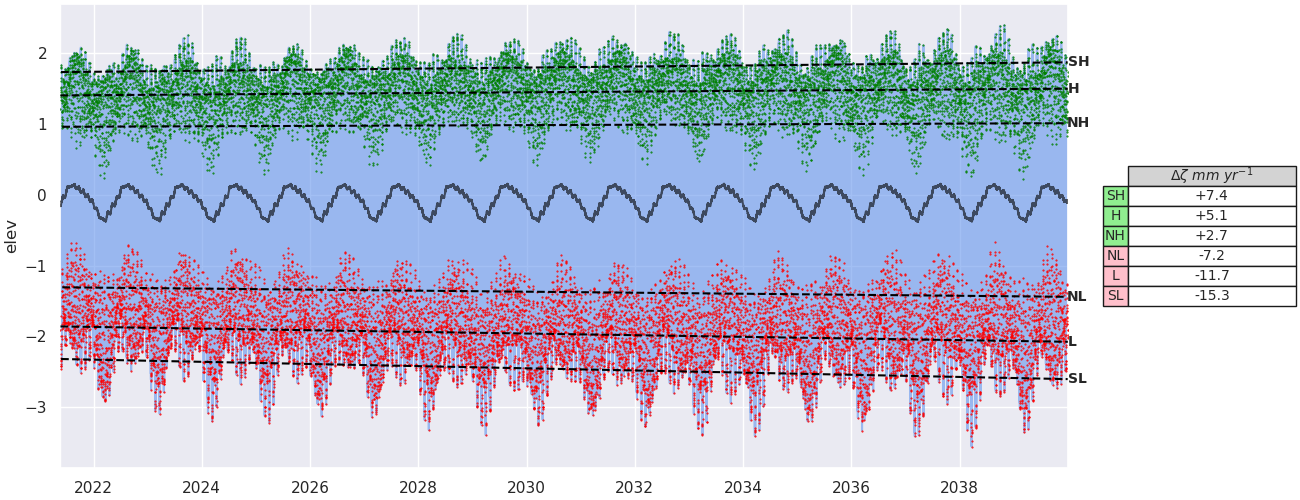

In [181]:
fig, (ax, tabax) = plt.subplots(figsize=(13, 5), ncols=2, gridspec_kw={'width_ratios': [6, 1]}, constrained_layout=True)

subset.elev.plot(kind="line", ax=ax, color="cornflowerblue", alpha=0.6, zorder=1);
subset.mean_roll.plot(kind="line", ax=ax, color="black", alpha=0.6, zorder=10);
subset.elev.loc[subset.high == True].reset_index().plot(kind="scatter", x="datetime", y="elev", color="green", marker=".", s=1, ax=ax, zorder=10);
subset.elev.loc[subset.low == True].reset_index().plot(kind="scatter", x="datetime", y="elev", color="red", marker=".", s=1, ax=ax, zorder=10);

cellText = []
rowLabels = []
for name, lm in lms.items():
    cellText.append(["{:+.1f}".format((lm.coef * 1000))])
    rowLabels.append(name)
    lm.ts.plot(ls="--", color="black", ax=ax, zorder=20);
    # ax.text(x=lm.ts.index.mean(), y=lm.ts.mean(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(lm.coef * 1000), fontsize="large", fontweight="bold");
    ax.text(x=lm.ts.index.max(), y=lm.ts[-1], ha="left", va="center", zorder=30, s="{}".format(name), fontsize="medium", fontweight="bold");

colLabels = ["$\Delta\zeta\ mm\ yr^{-1}$"]
colColours=["lightgray"]
rowColours=("lightgreen", "lightgreen", "lightgreen", "pink", "pink", "pink")

tabax.axis("off")
tabax.table(cellText=cellText, colLabels=colLabels, rowLabels=rowLabels, rowLoc="center", cellLoc="center", loc='center', colColours=colColours, rowColours=rowColours)
ax.xaxis.label.set_visible(False);
ax.set_xlim(subset.index[0], subset.index[-1]);